In [4]:
from tensorflow.examples.tutorials.mnist import input_data
minst=input_data.read_data_sets("minist_data/")

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting minist_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting minist_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting minist_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting minist_data/t10k-labels-idx1-ubyte.gz


In [20]:
from matplotlib import pyplot as plt
import numpy as np
import pickle
%matplotlib inline

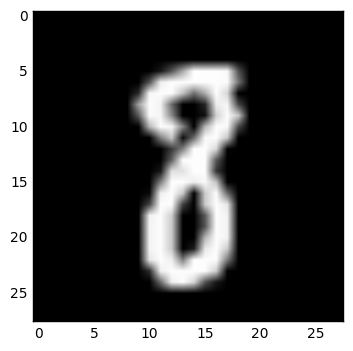

In [21]:
img =minst.train.images[50]
plt.imshow(img.reshape((28,28)),cmap="Greys_r")

In [22]:
import tensorflow as tf
def inputs(r_img_size,n_img_size):
    real_img=tf.placeholder(tf.float32,[None,r_img_size],name='read_img')
    noise_img=tf.placeholder(tf.float32,[None,n_img_size],name='noise_img')
    return real_img,noise_img

In [23]:
def g(noise_img,h_unit,out_dim,reuse=False,alpha=0.01):
    with tf.variable_scope('generator',reuse=reuse):
        hidden1=tf.layers.dense(noise_img,h_unit,reuse=reuse)
        hidden1=tf.maximum(alpha*hidden1,hidden1)
        hidden1=tf.layers.dropout(hidden1,rate=0.2)
        logits=tf.layers.dense(hidden1,out_dim)
        outputs=tf.tanh(logits)
        
        return logits,outputs

In [18]:
def d(img,h_unit,reuse=False,alpha=0.01):
    with tf.variable_scope('discriminator',reuse=reuse):
        hidden1=tf.layers.dense(img,h_unit)
        hidden1=tf.maximum(alpha*hidden1,hidden1)
        logits=tf.layers.dense(hidden1,1)
        outputs=tf.sigmoid(logits)
        return logits,outputs
    

In [24]:
img_size=minst.train.images[0].shape[0]
noise_size=100
g_units=128
d_units=128
alpha=0.01
learning_rate=0.001
smooth=0.1

In [28]:
tf.reset_default_graph()
real_img,noise_img=inputs(img_size,noise_size)
g_logits,g_outputs=g(noise_img,g_units,img_size)
d_logits_real,d_outputs_real=d(real_img,d_units)
d_logits_fake,d_outputs_fake=d(g_outputs,d_units,reuse=True)

In [29]:
# discriminator的loss
# 识别真实图片
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                     labels=tf.ones_like(d_logits_real)) * (1 - smooth))
# 识别生成的图片
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                     labels=tf.zeros_like(d_logits_fake)))
# 总体loss
d_loss = tf.add(d_loss_real, d_loss_fake)

# generator的loss
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                labels=tf.ones_like(d_logits_fake)) * (1 - smooth))

In [30]:
train_vars = tf.trainable_variables()

# generator中的tensor
g_vars = [var for var in train_vars if var.name.startswith("generator")]
# discriminator中的tensor
d_vars = [var for var in train_vars if var.name.startswith("discriminator")]

# optimizer
d_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)

In [37]:
# batch_size
batch_size = 64
# 训练迭代轮数
epochs = 300
# 抽取样本数
n_sample = 25

# 存储测试样例
samples = []
# 存储loss
losses = []
# 保存生成器变量
saver = tf.train.Saver(var_list = g_vars)
# 开始训练
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for batch_i in range(minst.train.num_examples//batch_size):
            batch = minst.train.next_batch(batch_size)
            
            batch_images = batch[0].reshape((batch_size, 784))
            # 对图像像素进行scale，这是因为tanh输出的结果介于(-1,1),real和fake图片共享discriminator的参数
            batch_images = batch_images*2 - 1
            
            # generator的输入噪声
            batch_noise = np.random.uniform(-1, 1, size=(batch_size, noise_size))
            
            # Run optimizers
            _ = sess.run(d_train_opt, feed_dict={real_img: batch_images, noise_img: batch_noise})
            _ = sess.run(g_train_opt, feed_dict={noise_img: batch_noise})
        
        # 每一轮结束计算loss
        train_loss_d = sess.run(d_loss, 
                                feed_dict = {real_img: batch_images, 
                                             noise_img: batch_noise})
        # real img loss
        train_loss_d_real = sess.run(d_loss_real, 
                                     feed_dict = {real_img: batch_images, 
                                                 noise_img: batch_noise})
        # fake img loss
        train_loss_d_fake = sess.run(d_loss_fake, 
                                    feed_dict = {real_img: batch_images, 
                                                 noise_img: batch_noise})
        # generator loss
        train_loss_g = sess.run(g_loss, 
                                feed_dict = {noise_img: batch_noise})
        
            
        print("Epoch {}/{}...".format(e+1, epochs),
              "Discriminator Loss: {:.4f}(Real: {:.4f} + Fake: {:.4f})...".format(train_loss_d, train_loss_d_real, train_loss_d_fake),
              "Generator Loss: {:.4f}".format(train_loss_g))    
        # 记录各类loss值
        losses.append((train_loss_d, train_loss_d_real, train_loss_d_fake, train_loss_g))
        
        # 抽取样本后期进行观察
        sample_noise = np.random.uniform(-1, 1, size=(n_sample, noise_size))
        gen_samples = sess.run(g(noise_img, g_units, img_size, reuse=True),
                               feed_dict={noise_img: sample_noise})
        samples.append(gen_samples)
        
        # 存储checkpoints
        saver.save(sess, './model/generator.ckpt')

# 将sample的生成数据记录下来
with open('train_samples.pkl', 'wb') as f:
    pickle.dump(samples, f)

Epoch 1/300... Discriminator Loss: 0.0378(Real: 0.0119 + Fake: 0.0258)... Generator Loss: 3.6183
Epoch 2/300... Discriminator Loss: 0.8716(Real: 0.4478 + Fake: 0.4238)... Generator Loss: 3.5305
Epoch 3/300... Discriminator Loss: 0.5626(Real: 0.3827 + Fake: 0.1799)... Generator Loss: 3.5838
Epoch 4/300... Discriminator Loss: 1.5695(Real: 0.6042 + Fake: 0.9653)... Generator Loss: 2.7858
Epoch 5/300... Discriminator Loss: 2.5763(Real: 1.6195 + Fake: 0.9568)... Generator Loss: 0.8879
Epoch 6/300... Discriminator Loss: 1.9687(Real: 0.9205 + Fake: 1.0482)... Generator Loss: 2.8733
Epoch 7/300... Discriminator Loss: 0.9616(Real: 0.4293 + Fake: 0.5324)... Generator Loss: 1.6306
Epoch 8/300... Discriminator Loss: 2.2971(Real: 0.8716 + Fake: 1.4255)... Generator Loss: 0.6265
Epoch 9/300... Discriminator Loss: 1.4613(Real: 0.8038 + Fake: 0.6575)... Generator Loss: 1.2031
Epoch 10/300... Discriminator Loss: 0.4438(Real: 0.2158 + Fake: 0.2280)... Generator Loss: 2.0479
Epoch 11/300... Discriminator

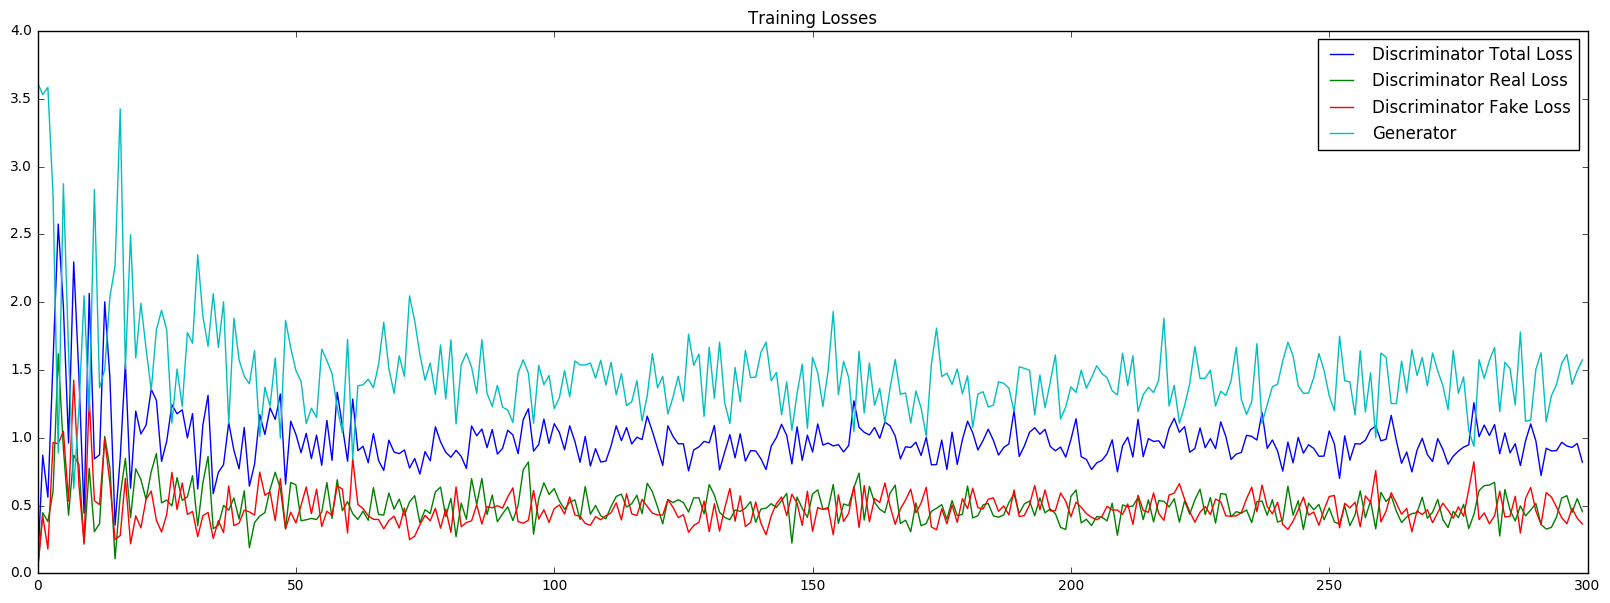

In [38]:
fig, ax = plt.subplots(figsize=(20,7))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator Total Loss')
plt.plot(losses.T[1], label='Discriminator Real Loss')
plt.plot(losses.T[2], label='Discriminator Fake Loss')
plt.plot(losses.T[3], label='Generator')
plt.title("Training Losses")
plt.legend()

In [39]:
# Load samples from generator taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pickle.load(f)
    
    

In [40]:
def view_samples(epoch, samples):
    """
    epoch代表第几次迭代的图像
    samples为我们的采样结果
    """
    fig, axes = plt.subplots(figsize=(7,7), nrows=5, ncols=5, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch][1]): # 这里samples[epoch][1]代表生成的图像结果，而[0]代表对应的logits
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
    
    return fig, axes

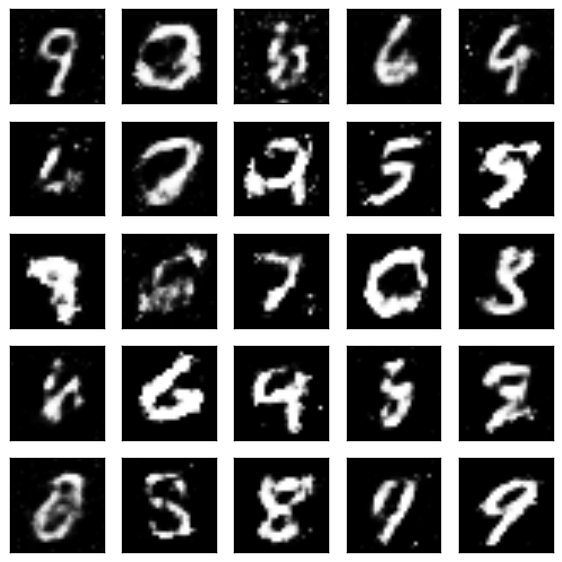

In [41]:
_ = view_samples(-1, samples) # 显示最后一轮的outputs

In [42]:
# 指定要查看的轮次
epoch_idx = [0, 5, 10, 20, 40, 60, 80, 100, 150, 250] # 一共300轮，不要越界
show_imgs = []
for i in epoch_idx:
    show_imgs.append(samples[i][1])

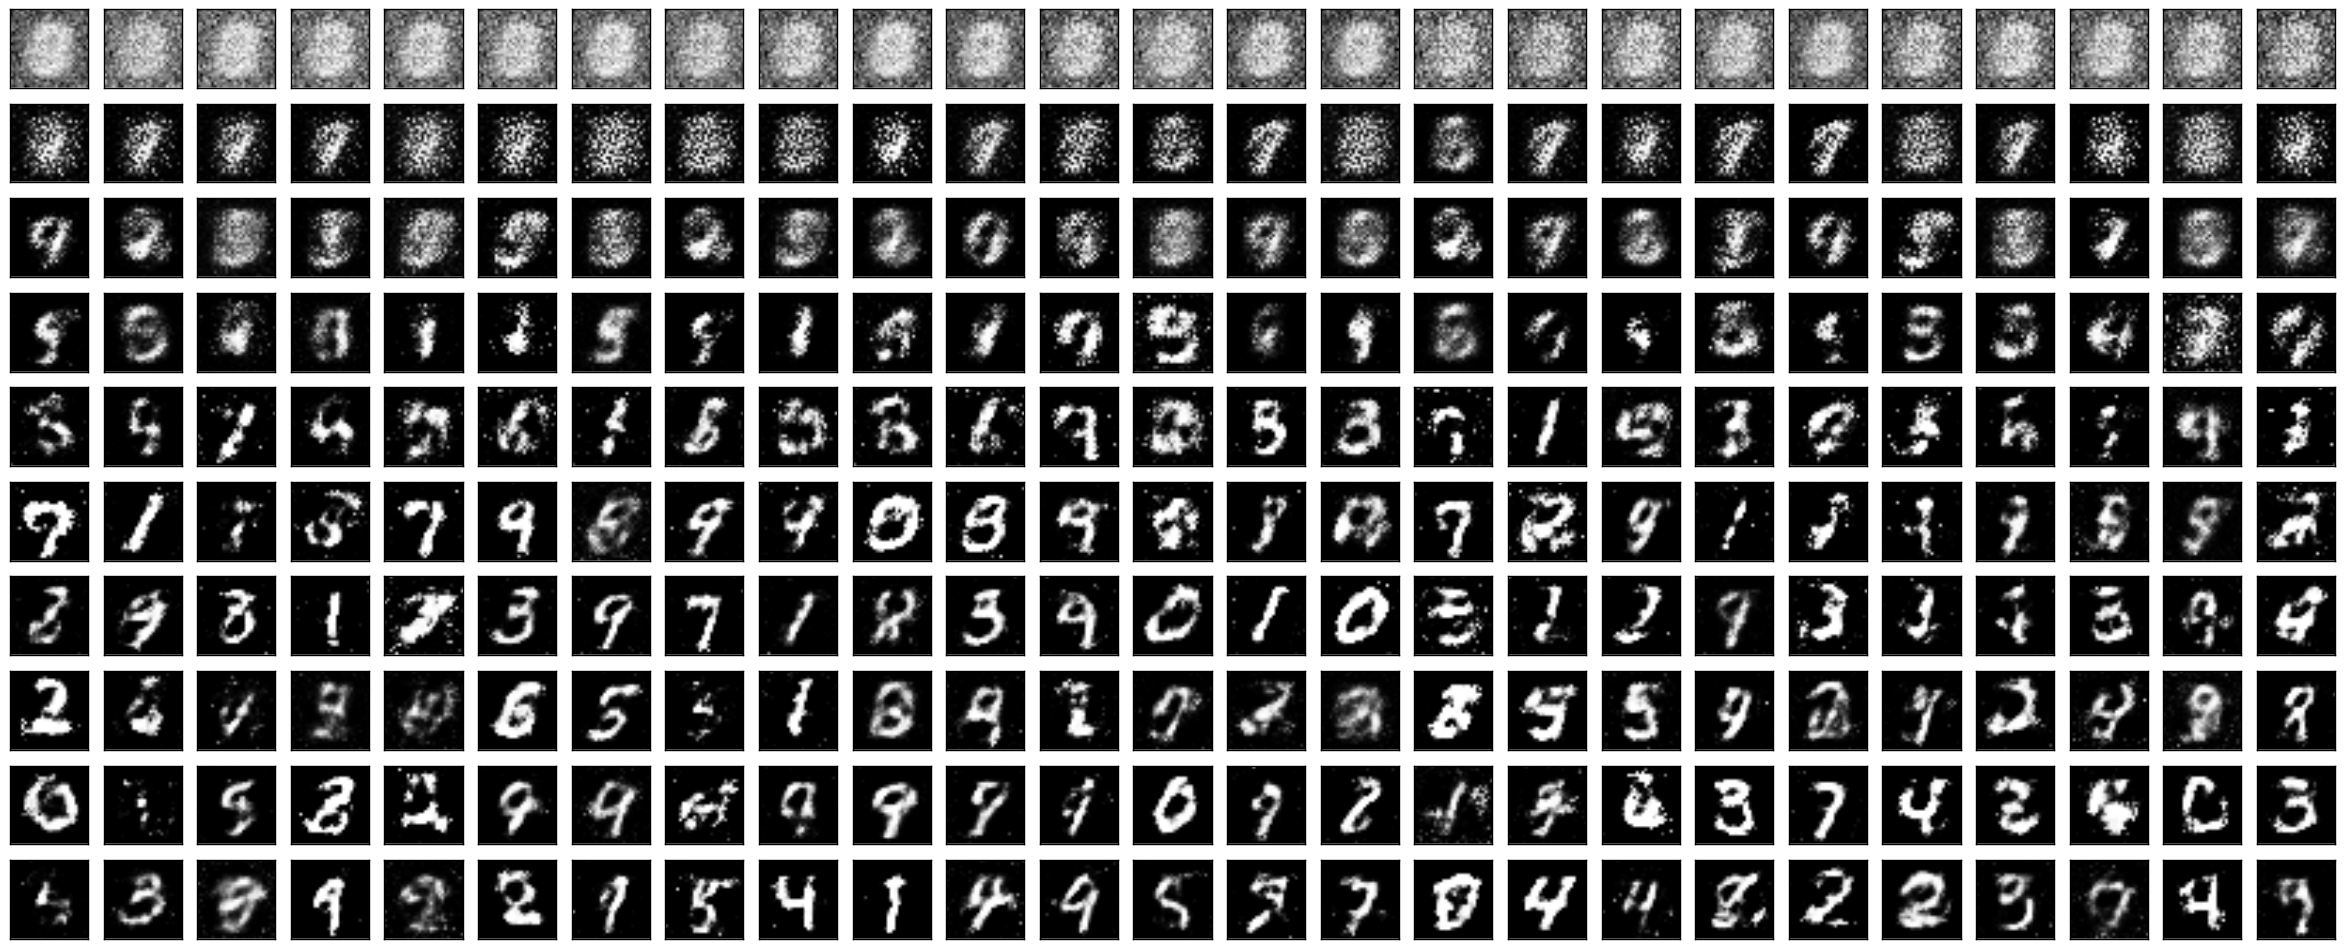

In [43]:
# 指定图片形状
rows, cols = 10, 25
fig, axes = plt.subplots(figsize=(30,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

idx = range(0, epochs, int(epochs/rows))

for sample, ax_row in zip(show_imgs, axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

In [44]:
# 加载我们的生成器变量
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    sample_noise = np.random.uniform(-1, 1, size=(25, noise_size))
    gen_samples = sess.run(get_generator(noise_img, g_units, img_size, reuse=True),
                           feed_dict={noise_img: sample_noise})

INFO:tensorflow:Restoring parameters from None


SystemError: <built-in function TF_Run> returned a result with an error set

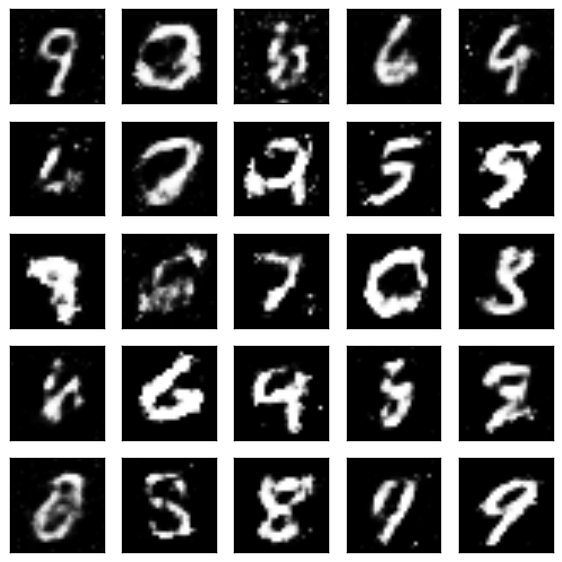

In [45]:
_ = view_samples(0, [gen_samples])